# Decision Trees

## In this notebook you will see the following:
1. Implementation of two impurity measures: Gini and Entropy.
1. Construction of a decision tree algorithm.
1. Pruning of the tree to achieve better results.
1. Visualizing of the results.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [3]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [4]:
data = data.dropna(axis= 1)

After removing stalk-root from dictionary, all information is valid. Stalk-root dosen't exist in the data

We will split the dataset to `Training` and `Testing` datasets.

In [5]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [6]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [7]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    gini = 1 - sum()
    """
    gini = 0.0
    label = data[:, -1]               # get all labels from the matrix
    poisonous = np.sum(label == 'p')  # number of poisonous labels 
    edible = np.sum(label == 'e')     # number of edible labels 
    all_labels = poisonous + edible   # number of all labels
    gini = 1 - (((poisonous / all_labels) ** 2) + ((edible / all_labels) ** 2)) # gini index according to formula
    return gini

In [8]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    label = data[:, -1]               # get all labels from the matrix
    poisonous = np.sum(label == 'p')  # number of poisonous labels 
    edible = np.sum(label == 'e')     # number of edible labels 
    all_labels = poisonous + edible   # number of all labels 
    if(poisonous == 0 or edible == 0):
        return 0;
    entropy = -((poisonous / all_labels) * np.log2(poisonous / all_labels) 
                + (edible / all_labels) * np.log2(edible / all_labels))   # entropy calculation according to formula 
    return entropy

In [9]:
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio. we'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [10]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    if gain_ratio: 
        impurity_func = calc_entropy 
    split_information = 0                 # split information initialized to 0
    impurity_feature = 0                  # impurity feature initialized to 0
    impurity_total = impurity_func(data)  # impurity before split
    feature_attribute = np.unique(data[:,feature])  # get a list of all chars associated with feature
    amount_instances = data.shape[0]      # get amount of instances in the data
    for letter in (feature_attribute):          # iterate letters associated with feature
        temp_array = data[data[ :,feature] == letter]  # making array from all instances that fit letter in this feature
        split_information -= ((temp_array.shape[0]) / (amount_instances)) * np.log2((temp_array.shape[0]) / (amount_instances))  # calculate split information according to formula 
        impurity_feature += (impurity_func(temp_array)) * ((temp_array.shape[0]) / (amount_instances))     # calculate impurity of feature according to formula 
    goodness = impurity_total - impurity_feature       # calculating goodness according to formula 
        
    if gain_ratio:                                   # if bool is asking for  Gain Ratio
         goodness = goodness / split_information     # calculate goodness as *gain ratio* according to formula
    return goodness  

In [11]:
goodness_of_split(X_train, 4, calc_entropy, gain_ratio=True)

0.2156152000173082

## Building a Decision Tree

We will use a Python class to construct the decision tree. Our class will support the following functionality:

1. Initiating a node for a decision tree. We will need to use several class methods and class attributes.
2. Our code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this notebook, when splitting a node, we will create the number of children needed according to the attribute unique values.

In [12]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature):
        self.feature = feature # column index of criteria being tested
        self.children = {}     # dictionary for child nodes
        self.pred = -1         # prediction value
        self.count_pred = 0    # amount of poisonous labels with this feature 
        self.count_not_pred = 0  # amount of edible labels with this feature 
        
    def add_child(self, attribute, node): # fucntion for adding child node
        self.children[attribute] = node
        
    def update_prediction(self, pred, count_pred ,count_not_pred): # function for updating prediction
        self.pred = pred
        self.count_pred = count_pred
        self.count_not_pred = count_not_pred

In [13]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None 
    root_feature, root_feature_attributes = find_best_feature(data, impurity, gain_ratio)  # finding best feature for root
    root = DecisionNode(root_feature) 
    pred, count_pred, count_not_pred = find_prediction(data)                               # finding root's prediction
    root.update_prediction(pred,count_pred, count_not_pred) 
    create_children(data, impurity, root, root_feature_attributes, gain_ratio, min_samples_split, max_depth) # creating children 
    return root

In [14]:
def find_best_feature(data, impurity, gain_ratio=False):
    max_gain = -1    # for saving maximum gain from splitting with feature
    best_feature_index = -1    # for saving index of best feature for splitting
    best_feature_attributes = [] # for saving the amount of branches created by feature 
    data_copy = data.copy()   # a copy of data
    data_copy_t = data_copy.T[:-1,:]
    for index_feature, feature in enumerate(data_copy_t):  # iterating all features (columns)
        col = data[:,index_feature]
        is_all_zero = np.all((col == 0))
        if not is_all_zero:
            temp_gain = goodness_of_split(data_copy, index_feature, impurity, gain_ratio)  # calculate gain from temp feature 
            if temp_gain > max_gain:  # checking if gain is maximum
                max_gain = temp_gain  
                best_feature_index = index_feature
    best_feature_attributes = np.unique(data[:,best_feature_index])
    return best_feature_index, best_feature_attributes

In [15]:
def create_children(data, impurity, father, attributes, gain_ratio=False, min_samples_split=1, max_depth=1000):
    if(data.shape[0] <= min_samples_split or max_depth == 0 ):  # base step 
        return
    
    if(impurity(data) == 0):  # base step
        return 
    
    data_copy = data.copy()
    for attribute in attributes:
        temp_data_feature = data_copy[data_copy[ :,father.feature] == attribute] # all instances with this attribute in this feature 
        temp_data_feature[:,father.feature] = np.zeros(temp_data_feature.shape[0])  # remove feature (make it zero) from all instances
        child_feature, child_feature_attributes = find_best_feature(temp_data_feature, impurity, gain_ratio)
        child = DecisionNode(child_feature)
        pred,count_pred, count_not_pred = find_prediction(temp_data_feature)
        child.update_prediction(pred,count_pred, count_not_pred)
        create_children(temp_data_feature, impurity, child, child_feature_attributes, gain_ratio, min_samples_split, max_depth - 1)
        father.add_child(attribute,child)

In [16]:
def find_prediction(data):
    label = data[:, -1]    # get all labels from the matrix
    count_p = np.sum(label == 'p') 
    count_e = np.sum(label == 'e') 
    if   count_p >=  count_e:  # find the most frequent label in the data
        return 'p', count_p, count_e 
    else:
        return 'e', count_e , count_p

In [17]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data = X_train, impurity = calc_gini) # gini and goodness of split
tree_entropy = build_tree(data = X_train, impurity = calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data = X_train, impurity = calc_entropy, gain_ratio = True) # entropy and gain ratio

print(tree_gini)
print(tree_entropy)
print(tree_entropy_gain_ratio)

## Tree evaluation

Here we will implement functions `predict` and `calc_accuracy`.

In [18]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    while(node.children):
        instance_feature_value = instance[node.feature] # get instance feature value
        pred = node.children.get(instance_feature_value,-1)
        if ( pred != -1):
            node = pred
        else:
            return node.pred
    return node.pred

In [19]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    succsess = 0
    for row in dataset:
        predict_value = predict(node,row)
        if predict_value == row[-1]:
            succsess +=1
    accuracy = (succsess * 100) / dataset.shape[0]
    return accuracy 

After building the three trees using the training set, we will calculate the accuracy on the test set. For each tree we will print the training and test accuracy. We will select the tree that gave us the best test accuracy. For the rest of the notebook, we will use that tree. 

In [21]:
print(f"Accuracy of tree using gini on:\n - the test data = {calc_accuracy(tree_gini,X_test)}% " +
      f"\n - the train data  = {calc_accuracy(tree_gini, X_train)}%")

print(f"Accuracy of tree using entropy on:\n - the test data = {calc_accuracy(tree_entropy, X_test)}% " +
      f"\n - the train data = {calc_accuracy(tree_entropy, X_train)}%")
      
print(f"Accuracy of tree using entropy with gain ratio on:\n - the test data = {calc_accuracy(tree_entropy_gain_ratio,X_test)}% " +
      f"\n - the train data = {calc_accuracy(tree_entropy_gain_ratio, X_train)}%")

Accuracy of tree using gini on:
 - the test data = 77.4987690792713% 
 - the train data  = 100.0%
Accuracy of tree using entropy on:
 - the test data = 78.04037419990152% 
 - the train data = 100.0%
Accuracy of tree using entropy with gain ratio on:
 - the test data = 79.02511078286558% 
 - the train data = 100.0%


## Depth pruning

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, we will construct a tree and prune it according to the max_depth value = we won't let the tree grow beyond this depth. Next, we will calculate the training and testing accuracy.<br>
On a single plot, we will draw the training and testing accuracy as a function of the max_depth. We will mark the best result on the graph with red circle.

In [22]:
calc_accuracy_train_depth = []
calc_accuracy_test_depth = []
trees_depth_test = []  # saving test trees for later
max_accuracy_test = [0, 0]
max_depth_values = [1,2,3,4,5,6,7,8]
for max_depth in max_depth_values: # iterating values
    tree_entropy_gain_ratio = build_tree(data = X_train, impurity = calc_entropy, gain_ratio = True, max_depth = max_depth) # entropy and gain ratio
    trees_depth_test.append(tree_entropy_gain_ratio)  # saving test trees for later
    calc_tmp_train = calc_accuracy(tree_entropy_gain_ratio, X_train)
    calc_tmp_test = calc_accuracy(tree_entropy_gain_ratio, X_test)
    calc_accuracy_train_depth.append(calc_tmp_train)
    calc_accuracy_test_depth.append(calc_tmp_test)
    if calc_tmp_test > max_accuracy_test[1]: # saving max value
        max_accuracy_test[0] = max_depth
        max_accuracy_test[1] = calc_tmp_test

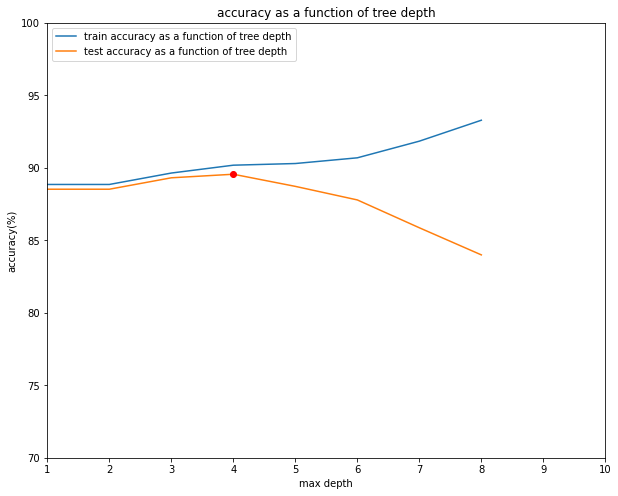

In [23]:
plt.plot(max_depth_values, calc_accuracy_train_depth, label = "train accuracy as a function of tree depth")
plt.plot(max_depth_values, calc_accuracy_test_depth, label = "test accuracy as a function of tree depth")
plt.legend(loc='upper left')
plt.xlabel('max depth')
plt.ylabel('accuracy(%)')
plt.title('accuracy as a function of tree depth')
plt.xlim(1,10)
plt.ylim(70,100)
plt.plot(max_accuracy_test[0],max_accuracy_test[1], 'ro')
plt.show()

## Min Samples Split

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, we will construct a tree and prune it according to the min_samples_split value = we won't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, we will calculate the training and testing accuracy.<br>
On a single plot, we will draw the training and testing accuracy as a function of the min_samples_split. we will mark the best result on the graph with red circle.

In [24]:
calc_accuracy_train_split = []
calc_accuracy_test_split = []
trees_split_test = []  # saving test trees for later
max_accuracy = [0, 0]
min_samples_split_values = [1,5,10,20,50]
for min_samples_split_value in min_samples_split_values:  # iterating values
    tree_entropy_gain_ratio = build_tree(data = X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = min_samples_split_value) # entropy and gain ratio
    trees_split_test.append(tree_entropy_gain_ratio)  # saving test trees for later
    calc_tmp_train = calc_accuracy(tree_entropy_gain_ratio, X_train)
    calc_tmp_test = calc_accuracy(tree_entropy_gain_ratio, X_test)
    calc_accuracy_train_split.append(calc_tmp_train)
    calc_accuracy_test_split.append(calc_tmp_test)
    if calc_tmp_test > max_accuracy[1]: # saving max value
        max_accuracy[0] = min_samples_split_value
        max_accuracy[1] = calc_tmp_test
        

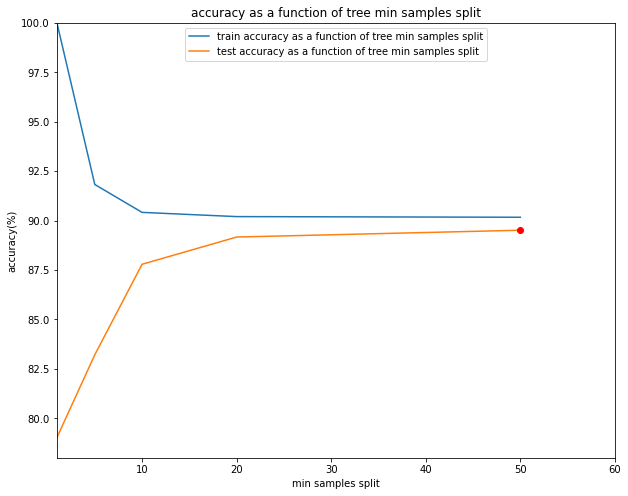

In [25]:
plt.plot(min_samples_split_values, calc_accuracy_train_split, label = "train accuracy as a function of tree min samples split")
plt.plot(min_samples_split_values, calc_accuracy_test_split, label = "test accuracy as a function of tree min samples split ")
plt.legend(loc='upper center')
plt.xlabel('min samples split')
plt.ylabel('accuracy(%)')
plt.title('accuracy as a function of tree min samples split')
plt.xlim(1,60)
plt.ylim(78,100)
plt.plot(max_accuracy[0],max_accuracy[1], 'ro')
plt.show()

Now we will build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [26]:
### using max_accuracy_test[0] as best max_depth and max_accuracy[0] for best min_samples_split
tree_max_depth = build_tree(data = X_train, impurity = calc_entropy, gain_ratio = True, max_depth = max_accuracy_test[0])
tree_min_samples_split = build_tree(data = X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = max_accuracy[0])

## Number of Nodes

This function counts_nodes prints the number of nodes in each tree.

In [32]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    if not node: # end of recursion
        return 0
    children = node.children.values() # get all child features
    count = 1
    for child in children: # iterate all children features
        count += count_nodes(child)
    return count

In [28]:
print(count_nodes(tree_max_depth))
print(count_nodes(tree_min_samples_split))

205
349


## Print the tree

Here we will print our tree in this example format:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

In [29]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    if(parent_feature == 'ROOT'): # beginning with root 
        print(f"[{parent_feature}, feature=X{node.feature}],")
    elif count_nodes(node) == 1: # printing for leaf
        dict_label = {}
        if node.count_pred:
            pred_p = 0
            if node.pred == 'e':
                dict_label[1.0] = node.count_pred
                pred_p = 1
            else:
                dict_label[0.0] = node.count_pred
            if node.count_not_pred: 
                dict_label[1.0-pred_p] = node.count_not_pred
        print(f"[X{parent_feature}={feature_val}, leaf]: [{dict_label}]")
        return
        
    else:
        print(f"[X{parent_feature}={feature_val}, feature=X{node.feature}]") # printing for node that is not leaf and not root
        
    for (branch,child) in node.children.items(): # recursion on all children
        print(depth * " ",end=' ')
        print_tree(child, depth+1, node.feature,branch)

Last, we will print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [31]:
best_test = [0, 0]  # array for best accuracy and best tree
trees = trees_depth_test + trees_split_test  # array with all test trees
accuracy = calc_accuracy_test_depth + calc_accuracy_test_split  # array with all test accuracy
for index in range(len(accuracy)): 
    if count_nodes(trees[index]) < 50 and accuracy[index] > best_test[0]:  # checking if less then 50 nodes and best accuracy
        best_test = [accuracy[index], trees[index]]
        
print_tree(best_test[1])

print(f"\n- Number of nodes = {count_nodes(best_test[1])}")
print(f"- Accuracy of tree = {best_test[0]}")

[ROOT, feature=X4],
 [X4=a, leaf]: [{1.0: 273, 0.0: 31}]
 [X4=c, leaf]: [{0.0: 137, 1.0: 10}]
 [X4=f, leaf]: [{0.0: 1438, 1.0: 170}]
 [X4=l, leaf]: [{1.0: 272, 0.0: 27}]
 [X4=m, leaf]: [{0.0: 25, 1.0: 2}]
 [X4=n, leaf]: [{1.0: 2332, 0.0: 344}]
 [X4=p, leaf]: [{0.0: 175, 1.0: 8}]
 [X4=s, leaf]: [{0.0: 380, 1.0: 38}]
 [X4=y, leaf]: [{0.0: 382, 1.0: 49}]

- Number of nodes = 10
- Accuracy of tree = 88.52781880846874
